In [ ]:
import pyvista as pv

import gmsh
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sps

gmsh.initialize()

In [ ]:
import gmsh
import matplotlib.pyplot as plt

import numpy as np
import sys
import gmsh


def triangle_max_edge(x):
    a = np.sum((x[:, 0, :] - x[:, 1, :]) ** 2, 1) ** 0.5
    b = np.sum((x[:, 0, :] - x[:, 2, :]) ** 2, 1) ** 0.5
    c = np.sum((x[:, 1, :] - x[:, 2, :]) ** 2, 1) ** 0.5
    return np.maximum(a, np.maximum(b, c))


class Mesh:
    def __init__(self):
        self.vtags, vxyz, _ = gmsh.model.mesh.getNodes()
        self.vxyz = vxyz.reshape((-1, 3))
        vmap = dict({j: i for i, j in enumerate(self.vtags)})
        self.triangles_tags, evtags = gmsh.model.mesh.getElementsByType(2)
        evid = np.array([vmap[j] for j in evtags])
        self.triangles = evid.reshape((self.triangles_tags.shape[-1], -1))


# def my_function(xyz):
#     a = 6 * (np.hypot(xyz[..., 0] - 0.5, xyz[..., 1] - 0.5) - 0.2)
#     f = np.real(np.arctanh(a + 0j))
#     return f


def my_function(xyz):
    a = np.hypot(xyz[..., 0] - 0.5, xyz[..., 1] - 0.5)
    return np.exp(-a / 0.2)


def compute_interpolation_error(nodes, triangles, f):
    uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
    jac, det, pt = gmsh.model.mesh.getJacobians(2, uvw)
    numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
    sf = sf.reshape((weights.shape[0], -1))
    qx = pt.reshape((triangles.shape[0], -1, 3))
    det = np.abs(det.reshape((triangles.shape[0], -1)))
    f_vert = f(nodes)
    f_fem = np.dot(f_vert[triangles], sf)
    err_tri = np.sum((f_fem - f(qx)) ** 2 * det * weights, 1)
    return f_vert, np.sqrt(err_tri)


def compute_size_field(nodes, triangles, err, N):
    x = nodes[triangles]
    a = 2.0
    d = 2.0
    fact = (a ** ((2.0 + a) / (1.0 + a)) + a ** (1.0 / (1.0 + a))) * np.sum(
        err ** (2.0 / (1.0 + a))
    )
    ri = (
        err ** (2.0 / (2.0 * (1 + a)))
        * a ** (1.0 / (d * (1.0 + a)))
        * ((1.0 + a) * N / fact) ** (1.0 / d)
    )
    return triangle_max_edge(x) / ri


gmsh.initialize()
gmsh.clear()

lc = 1.0

gmsh.model.add("square")
# square = gmsh.model.occ.addRectangle(
#     0, 0, 0, 1, 1
# )  ## Adding a square to the domain and return the tag of the square

gmsh.model.occ.addPoint(0, 0, 0, lc, 1)
gmsh.model.occ.addPoint(1, 0, 0, lc, 2)
gmsh.model.occ.addPoint(1, 0.5, 0, lc, 3)
gmsh.model.occ.addPoint(0.5, 0.5, 0, lc, 4)
gmsh.model.occ.addPoint(0.5, 1, 0, lc, 5)
gmsh.model.occ.addPoint(0, 1, 0, lc, 6)

gmsh.model.occ.addLine(1, 2, 1)
gmsh.model.occ.addLine(2, 3, 2)
gmsh.model.occ.addLine(3, 4, 3)
gmsh.model.occ.addLine(4, 5, 4)
gmsh.model.occ.addLine(5, 6, 5)
gmsh.model.occ.addLine(6, 1, 6)
cl = gmsh.model.occ.addCurveLoop([1, 2, 3, 4, 5, 6], 1)
square = gmsh.model.occ.addPlaneSurface([cl], 1)


gmsh.model.occ.synchronize()
pnts = gmsh.model.getBoundary(
    [(2, square)], True, True, True
)  ## Square is of dimension 2 and we get it's boundary using the tag
# print(pnts)
gmsh.model.addPhysicalGroup(1, np.array(pnts)[:, 1], 11)
gmsh.model.setPhysicalName(1, 11, "Boundary")

gmsh.model.addPhysicalGroup(2, [square], 1)
gmsh.model.setPhysicalName(2, 1, "Domain")

gmsh.model.mesh.setSize(pnts, lc)  ## Setting the size of the points
gmsh.model.mesh.generate(2)

gmsh.model.mesh.createEdges()

nodeTags, coord, param = gmsh.model.mesh.getNodes()
elementTags, nodeTagsTriangles = gmsh.model.mesh.getElementsByType(2)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000140583s, CPU 0.000162s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000481791s, CPU 0.000482s)
Info    : 8 nodes 20 elements


In [ ]:
def f(xy):
    return np.ones_like(xy[..., 0])


def g(xy):
    return np.sin(5 * xy[0]) * 0.0

/Users/prathamlalwani/miniconda3/envs/fenicsx-env/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


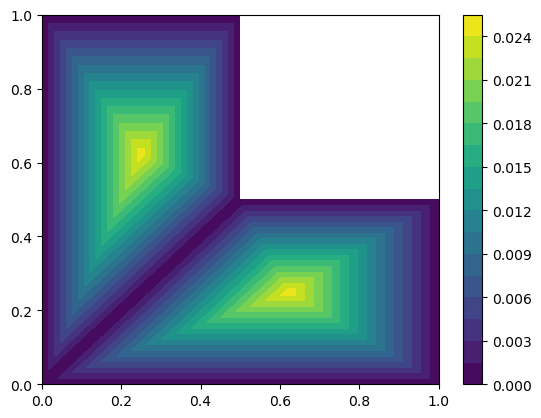

In [71]:
nodeTags, coords, _ = gmsh.model.mesh.getNodes()
nodeTypes = np.ones((np.max(np.array(nodeTags)) + 1,), dtype=np.int32)
nodeTypes[0] = 0
numMeshNodes = len(nodeTags)
grps = gmsh.model.getPhysicalGroups()
coords = coords.reshape(-1, 3)
matrowflat = np.array([], dtype=np.int32)
matcolflat = np.array([], dtype=np.int32)
matflat = np.array([])
rhsrowflat = np.array([], dtype=np.int32)
rhsflat = np.array([])
maxNodeTag = int(np.amax(nodeTags))


for grpDim, grpTag in grps:
    grp_name = gmsh.model.getPhysicalName(grpDim, grpTag)
    if grp_name == "Boundary":  ### Identify the boundary
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                nodeTypes[nodeTags] = 2
    if grp_name == "Domain":  ### Setup the stiffness matrix for 1-D
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                numElements = len(elementTags)
                numGroupNodes = len(nodeTags)
                enode = np.array(nodeTags, dtype=np.int32).reshape((numElements, -1))
                numElementNodes = enode.shape[1]

                prop = gmsh.model.mesh.getElementProperties(2)
                uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
                numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
                weights = np.array(weights)
                numGaussPoints = len(weights)
                sf = np.array(sf).reshape((numGaussPoints, -1))
                numcomp, dsfdu, _ = gmsh.model.mesh.getBasisFunctions(
                    2, uvw, "GradLagrange"
                )
                dsfdu = np.array(dsfdu).reshape((numGaussPoints, 3, 3))[:, :, :-1]
                qjac, qdet, qpoint = gmsh.model.mesh.getJacobians(2, uvw, 1)
                qdet = np.array(qdet).reshape((numElements, numGaussPoints))
                dxdu = np.array(qjac).reshape((numElements, numGaussPoints, 3, 3))[
                    :, :, :-1, :-1
                ]
                # jacobian stored by row, so dxdu[i][j] = dxdu_ij = dxi/duj

                # dudx[j][k] = dudx_jk = duj/dxk
                dudx = np.linalg.inv(dxdu)
                dsfdx = np.einsum("egxu,gnu->egnx", dudx, dsfdu)
                localmat = np.einsum("egik,egjk,eg,g->eij", dsfdx, dsfdx, qdet, weights)
                matcol = np.repeat(enode[:, :, None], numElementNodes, axis=2)
                matrow = np.repeat(enode[:, None, :], numElementNodes, axis=1)

                matcolflat = np.append(matcolflat, matcol.flatten())
                matrowflat = np.append(matrowflat, matrow.flatten())
                matflat = np.append(matflat, localmat.flatten())
                localrhs = np.einsum(
                    "gn,eg,eg,g->en",
                    sf,
                    qdet,
                    f(qpoint.reshape(numElements, numGaussPoints, 3)[:, :, :-1]),
                    weights,
                )
                rhsrowflat = np.append(rhsrowflat, enode.flatten())
                rhsflat = np.append(rhsflat, localrhs.flatten())

node2unknown = np.zeros(maxNodeTag + 1, dtype=np.int32)

index = 0

boundary_nodes = np.where(nodeTypes == 2)[0]
interior_nodes = np.where(nodeTypes == 1)[0]
node2unknown[interior_nodes] = np.arange(1, len(interior_nodes) + 1)
node2unknown[boundary_nodes] = np.arange(
    len(interior_nodes) + 1, len(interior_nodes) + 1 + len(boundary_nodes)
)

numUnknowns = len(interior_nodes)
index = np.max(node2unknown)
if index != numMeshNodes:
    print("Something went wrong")


unknown2node = np.zeros(numMeshNodes + 1, dtype=np.int32)
for node, unkn in enumerate(node2unknown):
    unknown2node[unkn] = node


globalmat = sps.coo_matrix(
    (matflat, (node2unknown[matcolflat] - 1, node2unknown[matrowflat] - 1)),
    shape=(numMeshNodes, numMeshNodes),
).tocsr()

globalrhs = np.zeros(numMeshNodes)
for index, node in enumerate(rhsrowflat):
    globalrhs[node2unknown[node] - 1] += rhsflat[index]

for index, node in enumerate(boundary_nodes):
    globalrhs[node2unknown[node] - 1] = g(coords[node])
for index, node in enumerate(boundary_nodes):
    globalmat[node2unknown[node] - 1, :] = 0
    globalmat[node2unknown[node] - 1, node2unknown[node] - 1] = 1


# sol = sps.linalg.spsolve(globalmat[:numUnknowns, :numUnknowns], globalrhs[:numUnknowns])
# sol = np.append(sol, np.zeros(numMeshNodes - numUnknowns))
sol = sps.linalg.spsolve(globalmat, globalrhs)

plt.tricontourf(
    coords.reshape(-1, 3)[:, 0],
    coords.reshape(-1, 3)[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
    sol[node2unknown[1:] - 1],
    levels=20,
)
plt.colorbar()
plt.show()

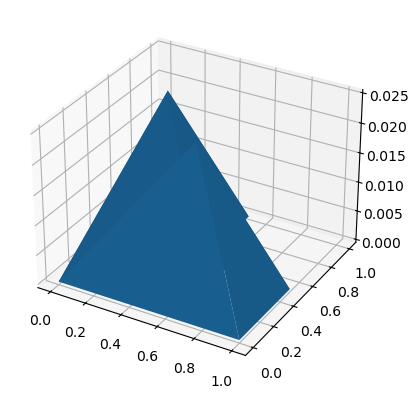

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(
    coords.reshape(-1, 3)[:, 0],
    coords.reshape(-1, 3)[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
    sol[node2unknown[1:] - 1],
    # levels=20,
)
# ax.colorbar()
plt.show()

In [73]:
gmsh.model.mesh.getElementType("triangle", 1)

2

In [75]:
edgeNodes = gmsh.model.mesh.getElementEdgeNodes(2)
edgeTags, edgeOrientations = gmsh.model.mesh.getEdges(edgeNodes)
elementTags, elementNodeTags = gmsh.model.mesh.getElementsByType(2)

edges2Elements = {}
faces2Elements = {}
for i in range(len(edgeTags)):  # 3 edges per triangle
    if not edgeTags[i] in edges2Elements:
        edges2Elements[edgeTags[i]] = [elementTags[i // 3]]
    else:
        edges2Elements[edgeTags[i]].append(elementTags[i // 3])

In [ ]:
gmsh.model.mesh.getJacobians(
    2,
)

array([5, 8, 7, 2, 3, 7, 1, 2, 8, 1, 4, 1, 7, 4, 1, 7, 4, 8, 5, 6, 6, 8,
       6, 1, 3, 4, 4, 5, 2, 3], dtype=uint64)

In [103]:
edges, edgeNodes = gmsh.model.mesh.getAllEdges()
edgeNodes, edges.shape

(array([5, 8, 7, 2, 3, 7, 1, 2, 8, 1, 4, 1, 7, 4, 1, 7, 4, 8, 5, 6, 6, 8,
        6, 1, 3, 4, 4, 5, 2, 3], dtype=uint64),
 (15,))

In [ ]:
elementTagsForEdge9 = edges2Elements[9]
_, nd, _, _ = gmsh.model.mesh.getElements(elementTagsForEdge9[0])
print(nd)
# cd, pcd, _, _ = gmsh.model.mesh.getNode(nd)
# gmsh.model.mesh.getJacobian(elementTagsForEdge9[0], pcd)
gmsh.model.mesh.getJacobians()

[1 7 4]


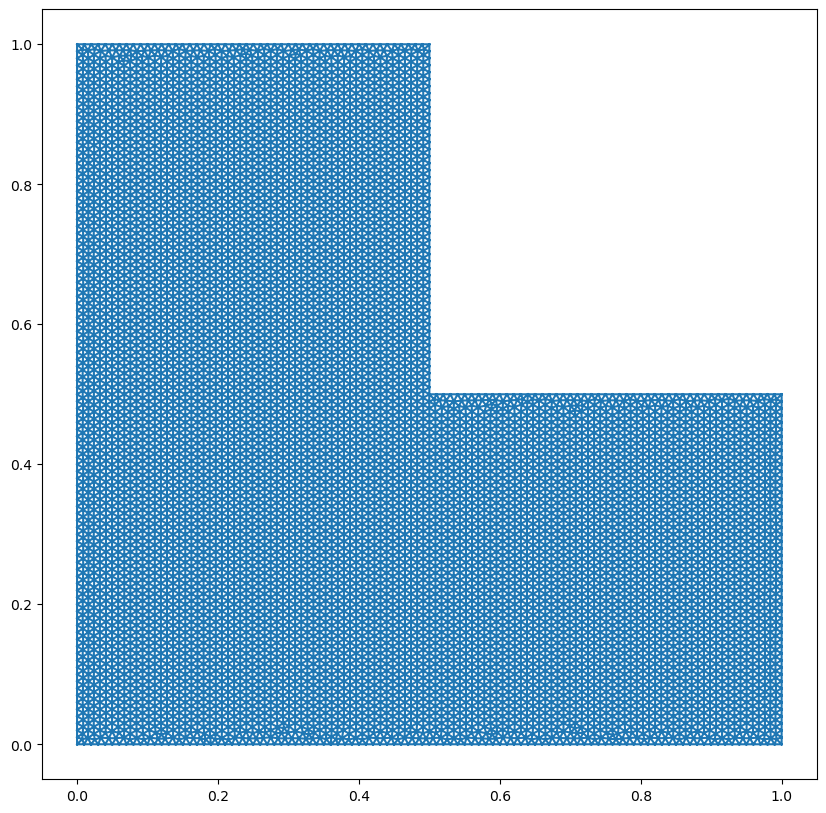

In [59]:
plt.figure(figsize=(10, 10))
plt.triplot(
    coord.reshape(-1, 3)[:, 0],
    coord.reshape(-1, 3)[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
)